In [2]:
import sys
import torch 
from torch.func import vmap, grad 
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from score_models import ScoreModel
from tqdm import tqdm

sys.path.append("../models/")
from posterior_sampling import euler_sampler, sigma, real_to_complex, complex_to_real
from forward_model import link_function, ft, ift
plt.style.use("dark_background")

device = "cuda" if torch.cuda.is_available() else "cpu"

ModuleNotFoundError: No module named 'posterior_sampling'

: 

In [2]:
# Loading the weights for a score model trained on a prior: 
skirt = "../../score_models/ncsnpp_vp_skirt_y_64_230813225149/"
probes = "../../score_models/ncsnpp_probes_g_64_230604024652/"

prior = probes

if "skirt" in prior: 
    prior_name = "skirt"
    norm = LogNorm(vmin= 1e-2, clip = True)
    B = 1
    C = 0
    def link_function(x): 
        return B * x + C
    print("Setting the Skirt's parameters...")

else: 
    prior_name = "probes"
    norm = None
    B = 1/2
    C = 1/2
    def link_function(x):
        return B * x + C
    print("Setting the Probes' parameters...")

score_model = ScoreModel(checkpoints_directory = prior)

Setting the Probes' parameters...
Using the Variance Exploding SDE


In [3]:
if "ve" in str(score_model.sde): 
    print("Yes")

Yes


In [4]:
params = {"x": 1, "y":2}
x,y = params.values()

In [5]:
x

1

In [5]:
data_path = "../../../data/"
prior_samples = torch.load(data_path + prior_name + "_prior_samples.pt")
sampling_function = torch.tensor(np.load(data_path + "\data_htlup\sampling_function3.npy"))[:256**2]

S = sampling_function.reshape(256, 256).to(device)

sample = prior_samples[0, 0]
padded_sample = torch.nn.functional.pad(prior_samples[0,0], [96, 96, 96, 96])

In [7]:
S

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]], device='cuda:0')

In [6]:
def dirty_imager(x, sampling_function): 
    dirty_image = ift(ft(x) * sampling_function.to(torch.uint8))
    return dirty_image.real

def padding(x, pad): 
    H, W = x.shape
    return torch.nn.functional.pad(x, [pad, pad, pad, pad])

def unpadding(x, pad):
    H, W = x.shape
    full_img = x.shape[-1]
    img_size = full_img - 2* pad
    T = (full_img+ img_size)//2 
    D = (full_img-img_size)//2 
    L = (full_img-img_size)//2 
    R = (full_img+ img_size)//2  
    return x[D:T,L:R].reshape(img_size, img_size)


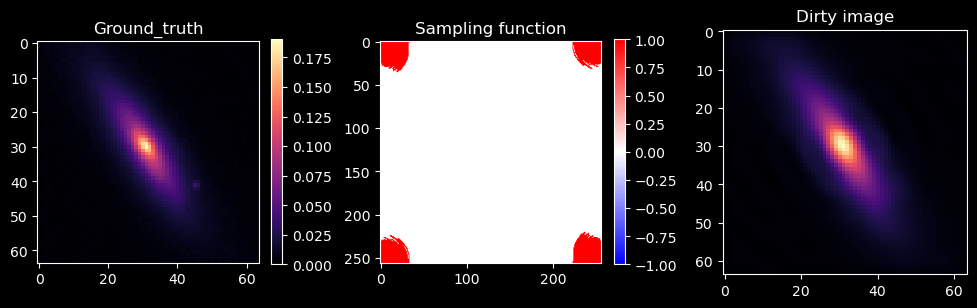

In [7]:
fig, axs = plt.subplots(1, 3, figsize = (3*4, 4))
    
padded_sample = padding(link_function(prior_samples[0,0]), pad = 96)
im = axs[0].imshow(unpadding(padded_sample, pad = 96).cpu().numpy(), norm = norm, cmap = "magma")
axs[0].set_title("Ground_truth")
plt.colorbar(im, ax = axs[0], fraction = 0.046)

im = axs[1].imshow(S.squeeze().cpu(), cmap = "bwr", vmin = -1)
plt.colorbar(im, ax = axs[1], fraction = 0.046)
axs[1].set_title("Sampling function")

dirty_image = dirty_imager(padded_sample, S)
dirty_image = unpadding(dirty_image, pad = 96)
axs[2].imshow(dirty_image.squeeze().cpu().numpy(), norm = norm, cmap = "magma")
axs[2].set_title("Dirty image")

plt.subplots_adjust(wspace=0.4)

In [8]:
from forward_model import model, model_to_plot

In [69]:
# from forward_model import noise_padding, link_function

# def complex_to_real(z):
#     """Convert a complex tensor into a real representation where the real
#     part and the imaginary part are concatenated 

#     Args:
#         z (torch.Tensor): complex tensor of dimension D 

#     Returns:
#         real tensor of dimensions 2*D
#     """
#     return torch.cat([z.real, z.imag], axis = -1)  

# def model(t, x, score_model, model_parameters): 
#     """Apply a physical model A to a ground-truth x.

#     Args:
#         t (torch.Tensor): temperature in the sampling procedure of diffusion models.
#         x (torch.Tensor): ground-truth 
#         score_model (torch.Tensor): trained score-based model (= the score of a prior)
#         model_parameters (Tuple): list of parameters for the model (sampling_function, B, C)
#           - index 0: sampling function (mask selecting the measured visibilities in Fourier space, must have a shape (H, W) where H and W are the height
#             and width of the padded image respectively)
#           - index 1 and index 2: B and C, the link_function parameters (see function link_function)

#     Returns:
#         y_hat (torch.Tensor): 
#     """

#     sampling_function, B, C, pad= model_parameters
#     num_vis = sampling_function.sum()

#     # To support batched input (note: the input is not batched during inference due to the vmap function)
#     if len(x.shape) == 4: 
#         N, _, H, W = x.shape
#         sampling_function = sampling_function.tile(N, 1, 1)
#     else: 
#         N = 1
#     x = link_function(x, B, C)   
#     x_padded = noise_padding(x, pad = pad, sigma = sigma(t, score_model))
#     vis_sampled = ft(x_padded).squeeze()[sampling_function] # some troublesome bug makes the squeeze needed here
    
#     vis_sampled = vis_sampled.reshape(N, num_vis)
#     y_hat = complex_to_real(vis_sampled)
#     return y_hat

In [56]:
S.sum()

tensor(3706, device='cuda:0')

In [11]:
t = torch.zeros(size = (1,1)).to(device)

pad = 96
model_parameters = (S, B, C, pad)
x = prior_samples[0]

# Creating an observation
sigma_y = 1e-2
y = model(t, x, score_model = score_model, model_parameters = model_parameters)
y += sigma_y * torch.randn_like(y)

In [10]:
x = torch.randn(size = (4, 1, 64, 64)).to(device)
model_parameters = (S, B, C, pad)
y = model(t, x, score_model = score_model, model_parameters = model_parameters)

In [65]:
y.shape

torch.Size([4, 7412])

In [43]:
S.tile(dims = (4,1,1))

tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

In [12]:
y_to_plot.shape

NameError: name 'y_to_plot' is not defined

Text(0.5, 1.0, 'Sampling function')

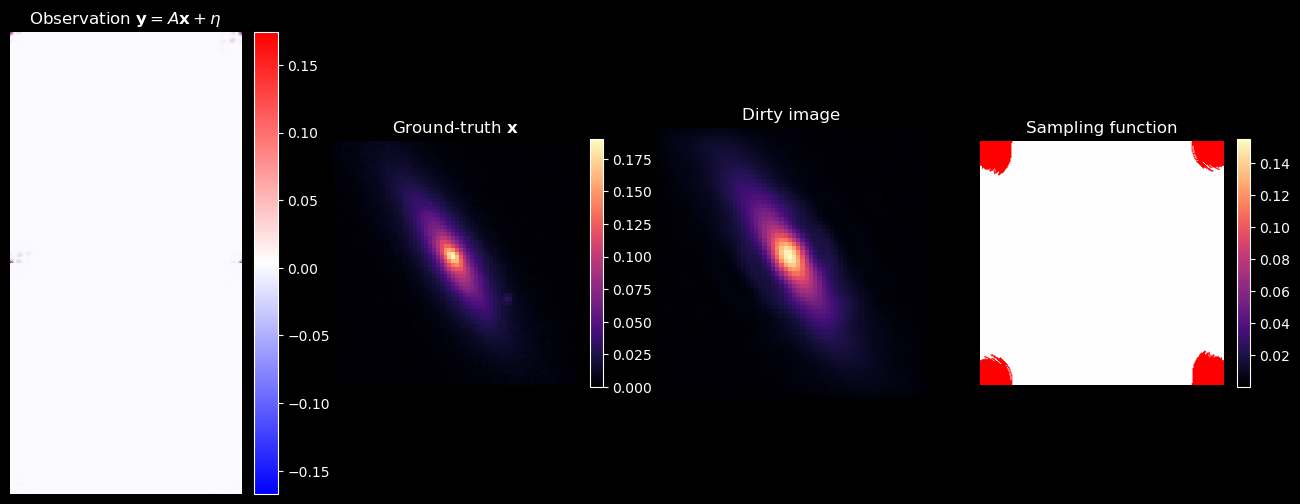

In [13]:
y_to_plot = model_to_plot(t, x, score_model = score_model, model_parameters = model_parameters)
dirty_image = unpadding(ift(real_to_complex(y_to_plot.squeeze())).real, pad = 96)

# Verifying I don't do weird stuff
n_cols = 4
fig, axs = plt.subplots(1, n_cols, figsize = (n_cols * 4, 6))

for i in range(n_cols): 
    axs[i].axis("off")

im = axs[0].imshow(y_to_plot.reshape(-1,256).cpu(), cmap = "bwr")
axs[0].set_title(r"Observation $\mathbf{y} = A\mathbf{x} +\eta$")
plt.colorbar(im, fraction = 2 * 0.046)
im = axs[1].imshow(link_function(x).squeeze().cpu(), norm = norm, cmap = "magma")
axs[1].set_title(r"Ground-truth $\mathbf{x}$")
plt.colorbar(im, fraction = 0.046)

im = axs[2].imshow(dirty_image.squeeze().cpu(), norm = norm, cmap = "magma")
axs[2].set_title("Dirty image")

m = axs[3].imshow(S.squeeze().cpu(), cmap = "bwr", vmin = -1)
plt.colorbar(im, ax = axs[3], fraction = 0.046)
axs[3].set_title("Sampling function")

In [14]:
from forward_model import score_likelihood, log_likelihood
from posterior_sampling import euler_sampler, old_pc_sampler, pc_sampler

In [15]:
# Sanity check
t = torch.ones(size = (1, 1)).to(device)
x = torch.randn(size = (1, 64, 64)).to(device)
log_likelihood(t, x, y, sigma_y, forward_model=model, score_model = score_model, model_parameters = model_parameters)

tensor(-1890.1167, device='cuda:0')

In [16]:
from posterior_sampling import mu, sigma, g, drift_fn
def score_posterior(t, x, y, sigma_y, forward_model, score_model, score_likelihood, model_parameters, tweedie):
    if tweedie: 
        sigma_t = sigma(t, score_model)[0].item() # During sampling every sample is evaluated at the same temperature so there's no issue with this
        mu_t = mu(t, score_model)[0].item()
        #tweedie_x = (x + sigma(t, score_model)**2 * score_model.score(t, x))/ mu(t, score_model)
        tweedie_x = (x + sigma_t ** 2 * score_model.score(t, x)) / mu_t
    else: 
        tweedie_x = x
    score_prior = score_model.score(t, x)
    score_lh = score_likelihood(t, tweedie_x, y, sigma_y, forward_model=forward_model, score_model=score_model, model_parameters = model_parameters)
    return score_prior + score_lh



In [19]:
num_samples = 4
pred_steps = 500
corr_steps = 20
snr = 0.1
samples = pc_sampler(
    y = y,
    sigma_y = sigma_y, 
    forward_model = model, 
    score_model = score_model, 
    score_likelihood = score_likelihood, 
    model_parameters = model_parameters,
    num_samples = num_samples,
    pc_params = (pred_steps, corr_steps, snr),
    img_size = (64, 64), 
    keep_chain = False, 
    debug_mode= False
)
# samples = euler_sampler(
#     y = y,
#     sigma_y = sigma_y, 
#     forward_model = model, 
#     score_model = score_model, 
#     score_likelihood = score_likelihood, 
#     model_parameters = model_parameters,
#     num_samples = num_samples,
#     num_steps = pred_steps,
#     img_size = (64, 64), 
#     keep_chain = False, 
#     debug_mode= False
# )

100%|██████████| 499/499 [02:14<00:00,  3.70it/s]


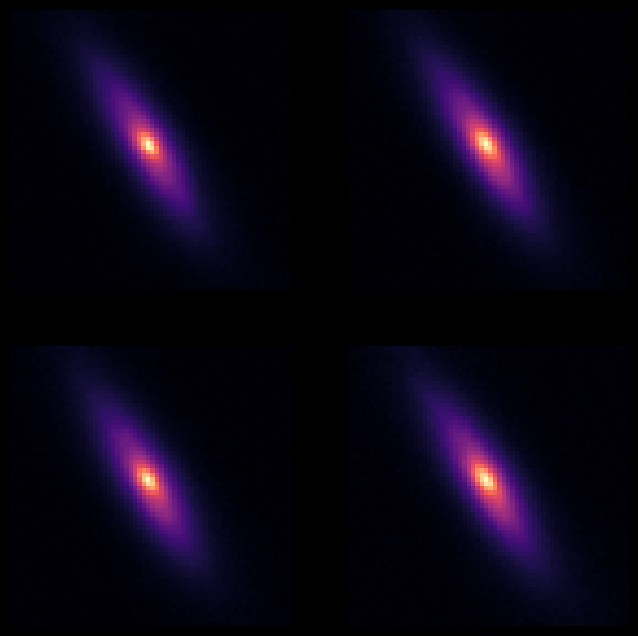

In [20]:
# Plotting results

fig, axs = plt.subplots(2, 2, figsize = (8, 8))

for i, ax in enumerate(axs.flatten()):
        ax.imshow(samples[i].squeeze().cpu(), cmap = "magma")
        ax.axis("off")


## Computing residuals 

The residuals are a way to evaluate how well a model is matching an observation. Let $\mathbf{y}$ be an observation respecting the following linear law 
$$
\mathbf{y} = A\mathbf{x} + \boldsymbol{\eta}  ,
$$
where $A$ is the forward model and $\boldsymbol{\eta}$ is a realization of an underlying noise distribution $p(\mathbf{y}|\mathbf{x})$. Let's now define $\hat{\mathbf{y}}= A\mathbf{x}$ our model's prediction. The residuals are obtained by doing the following operation 
$$
\mathbf{y} - \hat{\mathbf{y}} = \boldsymbol{\eta}\sim p(\mathbf{y}|\mathbf{x})
$$

The idea is that, if our forward model is good and encodes well the process mapping $\mathbf{x}$ to $\hat{\mathbf{y}}$, then when we substract the observation and the model's prediction, the only thing left is going to be pure noise, called the residuals.  

In [28]:
y_hat = model(t=torch.zeros(size = (1, 1)).to(device), x = samples, score_model = score_model, model_parameters =model_parameters)
y_hat_true =  model(t=torch.zeros(size = (1, 1)).to(device), x = prior_samples[0], score_model = score_model, model_parameters =model_parameters)

In [22]:
y_hat.shape

torch.Size([4, 7412])

In [29]:
def torch_to_numpy(x): 
    if type(x) == np.ndarray:
        return x 
    else: 
        return x.detach().cpu().numpy()

In [38]:
type(y_hat)

numpy.ndarray

In [39]:
y = torch_to_numpy(y).flatten()
y_hat = torch_to_numpy(y_hat).flatten()
y_hat_true = torch_to_numpy(y_hat_true).flatten()

In [40]:
chi_squared_pred = np.sum((y-y_hat) ** 2) / (sigma_y ** 2)
chi_squared_true = np.sum((y-y_hat_true) ** 2) / (sigma_y ** 2)
print(chi_squared_pred)
print(chi_squared_true)

7328.754663467407
7246.203422546387


In [27]:
y_hat_true.shape

(1, 7412)

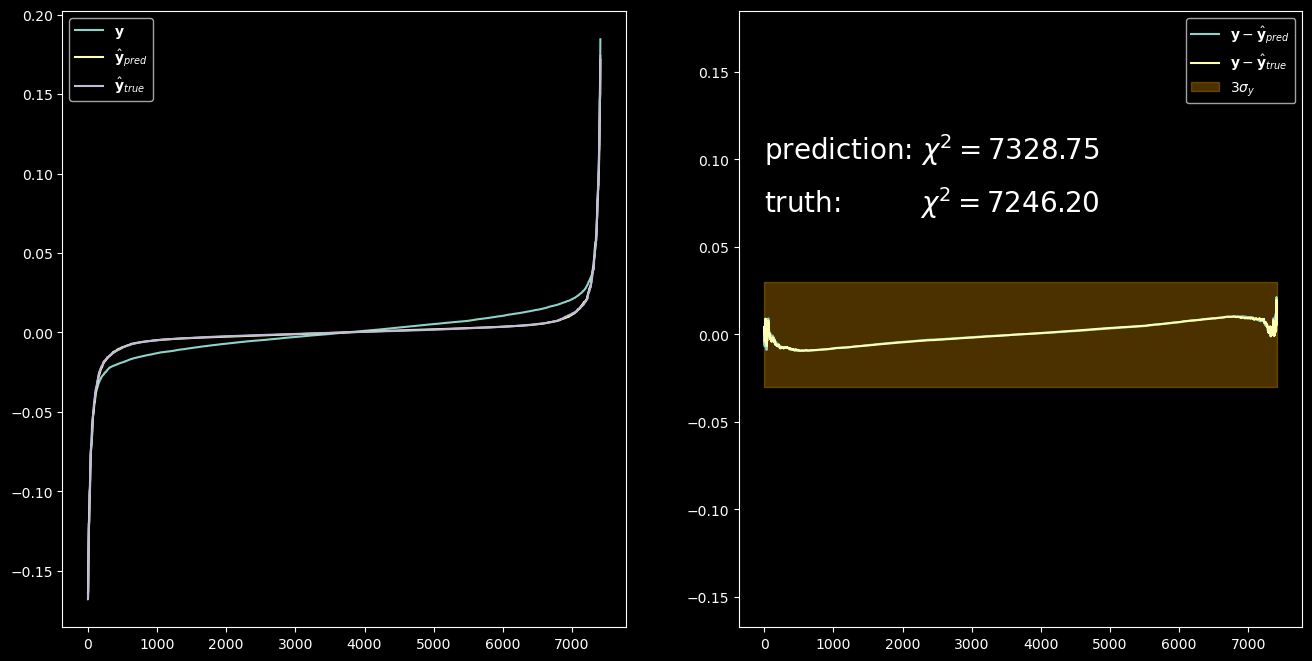

In [41]:
fig, axs = plt.subplots(1, 2, figsize = (16, 8))
axs[0].plot(np.sort(y), label = r"$\mathbf{y}$")
axs[0].plot(np.sort(y_hat), label = r"$\hat{\mathbf{y}}_{pred}$")
axs[0].plot(np.sort(y_hat_true), label = r"$\hat{\mathbf{y}}_{true}$")
axs[0].legend()
axs[1].plot(np.sort(y) - np.sort(y_hat), label = r"$\mathbf{y}-\hat{\mathbf{y}}_{pred}$")
axs[1].plot(np.sort(y) - np.sort(y_hat_true), label = r"$\mathbf{y}-\hat{\mathbf{y}}_{true}$")
axs[1].set(ylim = [y.min(), y.max()])
axs[1].fill_between(x = [0, len(y)], y1 = -3 * sigma_y, y2 = 3 * sigma_y, label = r"$3 \sigma_y$", color = "orange", alpha = 0.3)
axs[1].text(x = 0.2, y = 0.1, s = rf"prediction: $\chi^2 = {chi_squared_pred:.2f}$", fontsize = 20)
axs[1].text(x = 0.2, y = 0.07, s =rf"truth:         $\chi^2 = {chi_squared_true:.2f}$", fontsize = 20)
axs[1].legend()